<h1> Exercícios Resolvidos ICD - Aula 6 </h1>

Edesio Alcobaça (edesio@usp.br)<br>


MBA em Ciência de Dados <br>
Universidade de São Paulo, São Carlos, Brasil<br>
Copyright (c) 2021

### Exercícios de fixação

Não é necessário entregar os exercícios abaixo, mas é importante resolvê-los para fixar os conteúdos estudados.

1 - Repita todos os passos acima para a base de dados BreastCancer.

2 - Compare os três metodos de classificação para a base vertebralcolumn-3C.

3 - Faça a classificação dos dados gerados artificialmente com o código abaixo. Gere as regiões de separação para os métodos estudados nessa aula.

```python
from sklearn import datasets
plt.figure(figsize=(6,4))

n_samples = 1000

data  = datasets.make_moons(n_samples=n_samples, noise=.05)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)
```

<h2> 1 - Repita todos os passos acima para a base de dados BreastCancer. </h2>

Carregar bibliotecas necessárias para execução:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

Ler conjunto de dados e estudá-lo:

In [2]:
data = pd.read_csv("data/BreastCancer.csv", header=(0))
data["Class"] = data["Class"].astype("category")

lin, col = data.shape
print(f"Number of features: {col-1}")
print(f"Number of examples: {lin}")

Number of features: 10
Number of examples: 699


In [3]:
# olhar os 10 primeiros exemplos
# data[data.columns[5]].plot.hist()
data.head(10)

Id  Cl.thickness  Cell.size  Cell.shape  Marg.adhesion  Epith.c.size  \
0  1000025             5          1           1              1             2   
1  1002945             5          4           4              5             7   
2  1015425             3          1           1              1             2   
3  1016277             6          8           8              1             3   
4  1017023             4          1           1              3             2   
5  1017122             8         10          10              8             7   
6  1018099             1          1           1              1             2   
7  1018561             2          1           2              1             2   
8  1033078             2          1           1              1             2   
9  1033078             4          2           1              1             2   

   Bare.nuclei  Bl.cromatin  Normal.nucleoli  Mitoses Class  
0          1.0            3                1        1     0  
1         10.0            3                2        1     0  
2          2.0            3                1        1     0  
3          4.0            3                7        1     0  
4          1.0            3                1        1     0  
5         10.0            9                7        1     1  
6         10.0            3                1        1     0  
7          1.0            3                1        1     0  
8          1.0            1                1        5     0  
9          1.0            2                1        1     0

In [4]:
# verificar se existem NaN
data.isnull().values.any()

True

Vamos remover a coluna ID e remover exemplos com NaN:

In [5]:
data = data.dropna(axis="rows") # remove NaN
data = data.drop("Id", axis=1) # remove Id

lin, col = data.shape
print(f"Number of features: {col-1}")
print(f"Number of examples: {lin}")

Number of features: 9
Number of examples: 683


In [6]:
# descrever a coluna classe
data["Class"].describe()

count     683
unique      2
top         0
freq      444
Name: Class, dtype: int64

In [7]:
# frequencia das classes
data["Class"].value_counts() / data.shape[0]

0    0.650073
1    0.349927
Name: Class, dtype: float64

In [8]:
# descrição do conjunto de dados
data.describe()

Cl.thickness   Cell.size  Cell.shape  Marg.adhesion  Epith.c.size  \
count    683.000000  683.000000  683.000000     683.000000    683.000000   
mean       4.442167    3.150805    3.215227       2.830161      3.234261   
std        2.820761    3.065145    2.988581       2.864562      2.223085   
min        1.000000    1.000000    1.000000       1.000000      1.000000   
25%        2.000000    1.000000    1.000000       1.000000      2.000000   
50%        4.000000    1.000000    1.000000       1.000000      2.000000   
75%        6.000000    5.000000    5.000000       4.000000      4.000000   
max       10.000000   10.000000   10.000000      10.000000     10.000000   

       Bare.nuclei  Bl.cromatin  Normal.nucleoli     Mitoses  
count   683.000000   683.000000       683.000000  683.000000  
mean      3.544656     3.445095         2.869693    1.603221  
std       3.643857     2.449697         3.052666    1.732674  
min       1.000000     1.000000         1.000000    1.000000  
25%       1.000000     2.000000         1.000000    1.000000  
50%       1.000000     3.000000         1.000000    1.000000  
75%       6.000000     5.000000         4.000000    1.000000  
max      10.000000    10.000000        10.000000   10.000000

Após análise inicial dos dados, vamos dividir-los para então aplicar os algoritmos de AM:

In [9]:
features = data.drop("Class", axis=1)
target = data["Class"]

X = features.values
y = target.values
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(683, 9) (683,)
(546, 9) (546,)
(137, 9) (137,)


<h3> Classificação com K-Nearest Neighbors (KNN) </h3>

Antes de usar o KNN é necessário fazer com que cada feature tenha o mesmo peso para o classificador.<br>
Para isso podemos usar o <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a>

StandardScaler vai padronizar a feature movendo a média e variância para 0 e 1 respectivamente.<br>
Para a amostra x o calculo é feito como segue:

$z = \dfrac{(x - \mu)}{\sigma}$
    

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

mean_X_train_std = np.mean(X_train_std, axis=0)
var_X_train_std = np.var(X_train_std, axis=0)
print(f"Mean: {mean_X_train_std}")
print(f"Mean: {var_X_train_std}")

Mean: [-1.18749129e-16 -3.49740587e-17 -1.50469787e-16 -3.98541599e-17
  2.46445111e-16  2.72472317e-17 -1.61043340e-16 -9.76020241e-18
  3.25340080e-18]
Mean: [1. 1. 1. 1. 1. 1. 1. 1. 1.]


Para isso, podemos usar a classe 
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">KNeighborsClassifier</a>, que gera 'modelos' do algoritmo KNN.

In [11]:
# cria um objeto que representa o algoritmo KNN
model = KNeighborsClassifier(
    n_neighbors= 2, # número de vizinhos
    metric= 'euclidean' # métrica
)

# Cria o "modelo" para o KNN com o método "fit"
# Aqui usamos os dados de treino para gerar o modelo
model.fit(
    X_train_std, # features/atributos de TREINO
    y_train # target/classe de TREINO
)

# faz a predição no conjunto com o método 'predict'
y_pred = model.predict(X_test_std)

O erro na classificação pode ser quantificado pela medida de acurácia:

In [12]:
acc = round(accuracy_score(y_test, y_pred), 2)
print(f"Accuracy: {acc}")

Accuracy: 0.92


O valor de $k$ (i.e., <mark>n_neighbors</mark>) também pode ser ajustado e a acurácia pode variar bastante dependendo desse valor.<br>
Vamos utilizar a validação cruzada (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html">cross_validate</a>) para selecionar esse valor :


In [13]:
folds = 10 # numero de folds
k_values = [] # armazena os valores de k
acc_train = []
acc_test = []
k_max = 20

for k in range(1, k_max+1):
    # cria modelo
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    
    # realiza a validação cruzada
    cv = cross_validate(model, X_train_std, y_train, cv=folds, return_train_score=True)
    # print(cv)
    #print('k:', k, 'accurace:', cv['test_score'].mean())
    acc_train.append(cv['train_score'].mean()) 
    acc_test.append(cv['test_score'].mean()) 
    k_values.append(k)


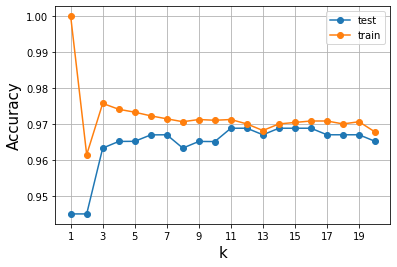

Best k is : 11


In [14]:
plt.plot(k_values, acc_test, "-o", label="test")
plt.plot(k_values, acc_train, "-o", label="train")
plt.xlabel("k", fontsize= 15)
plt.ylabel("Accuracy", fontsize= 15)
plt.xticks(np.arange(1, k_max+1, 2))
plt.grid()
plt.legend(loc="best")
plt.show(True)

best_k = k_values[np.argmax(acc_test)]
print('Best k is :', best_k)

Agora, usando todo o conjunto de dados vamos gerar o modelo final e testar no conjunto de teste previamente separado:

In [15]:
knn_model = KNeighborsClassifier(n_neighbors=best_k, metric = 'euclidean')
knn_model.fit(X_train_std, y_train)
y_pred = knn_model.predict(X_test_std)

acc = round(accuracy_score(y_test, y_pred), 2)
print(f"Accuracy: {acc}")

Accuracy: 0.96


<h3> Classificação com Logistic Regression (LR) </h3>

Para isso, podemos usar a classe 
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">LogisticRegression</a>, que gera modelos do algoritmo LR.

Você também pode normalizar e usar os dados normalizados. Isso ajudará na convergencia mas não é necessário para todos os solvers.<br>
Portanto, vamos usar os dados normalizados, apenas para ajudar na convergencia do solver. <br>

In [16]:
lr_model = LogisticRegression(max_iter = 1000)
lr_model.fit(X_train_std, y_train)
y_pred = lr_model.predict(X_test_std)

acc = round(accuracy_score(y_test, y_pred), 2)
print(f"Accuracy: {acc}")

Accuracy: 0.96


Sem os dados normalizados:

In [17]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = round(accuracy_score(y_test, y_pred), 2)
print(f"Accuracy: {acc}")

Accuracy: 0.96


<h3> Classificação com Naive Bayes (NB) </h3>

Para isso, podemos usar a classe 
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB">GaussianNB</a>, que gera modelos do algoritmo NB.

In [18]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

acc = round(accuracy_score(y_test, y_pred), 2)
print(f"Accuracy: {acc}")

Accuracy: 0.96


<h2> 2 - Compare os três metodos de classificação para a base vertebralcolumn-3C. </h2>

Neste exercício vamos comparar o KNN, NB e LR.

Carregar bibliotecas necessárias para execução:

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Ler conjunto de dados e estudá-lo:

In [20]:
data = pd.read_csv("data/vertebralcolumn-3C.csv", header=(0))

lin, col = data.shape
print(f"Number of features: {col-1}")
print(f"Number of examples: {lin}")

Number of features: 6
Number of examples: 310


In [21]:
# olhar os 10 primeiros exemplos
# data[data.columns[5]].plot.hist()
data.head(10)

pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0         63.027817    22.552586              39.609117     40.475232   
1         39.056951    10.060991              25.015378     28.995960   
2         68.832021    22.218482              50.092194     46.613539   
3         69.297008    24.652878              44.311238     44.644130   
4         49.712859     9.652075              28.317406     40.060784   
5         40.250200    13.921907              25.124950     26.328293   
6         53.432928    15.864336              37.165934     37.568592   
7         45.366754    10.755611              29.038349     34.611142   
8         43.790190    13.533753              42.690814     30.256437   
9         36.686353     5.010884              41.948751     31.675469   

   pelvic_radius  degree_spondylolisthesis   class  
0      98.672917                 -0.254400  Hernia  
1     114.405425                  4.564259  Hernia  
2     105.985135                 -3.530317  Hernia  
3     101.868495                 11.211523  Hernia  
4     108.168725                  7.918501  Hernia  
5     130.327871                  2.230652  Hernia  
6     120.567523                  5.988551  Hernia  
7     117.270067                -10.675871  Hernia  
8     125.002893                 13.289018  Hernia  
9      84.241415                  0.664437  Hernia

In [22]:
# verificar se existem NaN
data.isnull().values.any()

False

In [23]:
# descrever a coluna classe
data["class"].describe()

count                   310
unique                    3
top       Spondylolisthesis
freq                    150
Name: class, dtype: object

In [24]:
# frequencia das classes
data["class"].value_counts() / data.shape[0]

Spondylolisthesis    0.483871
Normal               0.322581
Hernia               0.193548
Name: class, dtype: float64

In [25]:
# descrição do conjunto de dados
data.describe()

pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
count        310.000000   310.000000             310.000000    310.000000   
mean          60.496653    17.542822              51.930930     42.953831   
std           17.236520    10.008330              18.554064     13.423102   
min           26.147921    -6.554948              14.000000     13.366931   
25%           46.430294    10.667069              37.000000     33.347122   
50%           58.691038    16.357689              49.562398     42.404912   
75%           72.877696    22.120395              63.000000     52.695889   
max          129.834041    49.431864             125.742385    121.429566   

       pelvic_radius  degree_spondylolisthesis  
count     310.000000                310.000000  
mean      117.920655                 26.296694  
std        13.317377                 37.559027  
min        70.082575                -11.058179  
25%       110.709196                  1.603727  
50%       118.268178                 11.767933  
75%       125.467675                 41.287352  
max       163.071041                418.543082

In [26]:
features = data.drop("class", axis=1)
target = data["class"]

X = features.values
y = target.values
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(310, 6) (310,)
(248, 6) (248,)
(62, 6) (62,)


In [27]:
models = [
    ("KNN5", Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5, metric= "euclidean"))
    ])),
    ("KNN10", Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=10, metric= "euclidean"))
    ])),
    ('NB', GaussianNB()),
    ('RL', LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000))
]

In [28]:
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Evaluating model from {name} ...")
    
    # teste depois o report, ele apresentará a você diversas métricas
    # report = classification_report(y_test, y_pred)
    # print(report)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy ({name}): {round(acc, 2)}")

Evaluating model from KNN5 ...
Accuracy (KNN5): 0.79
Evaluating model from KNN10 ...
Accuracy (KNN10): 0.81
Evaluating model from NB ...
Accuracy (NB): 0.87
Evaluating model from RL ...
Accuracy (RL): 0.87


<h2> 3 - Faça a classificação dos dados gerados artificialmente com o código abaixo. Gere as regiões de separação para os métodos estudados nessa aula. </h2>

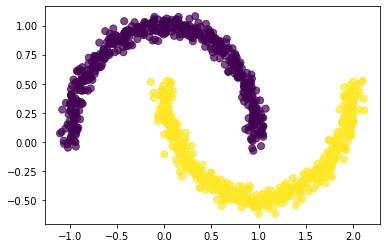

In [29]:
from sklearn import datasets
from mlxtend.plotting import plot_decision_regions


plt.figure(figsize=(6,4))

n_samples = 1000
data  = datasets.make_moons(n_samples=n_samples, noise=.05, random_state=42)

X = data[0]
y = data[1]

plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)

In [30]:
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1000, 2) (1000,)
(800, 2) (800,)
(200, 2) (200,)


In [31]:
models = [
    ("KNN", Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=3, metric= "euclidean"))
    ])),
    ('NB', GaussianNB()),
    ('RL', LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000))
]

Evaluating model from KNN ...
Accuracy (KNN): 1.0


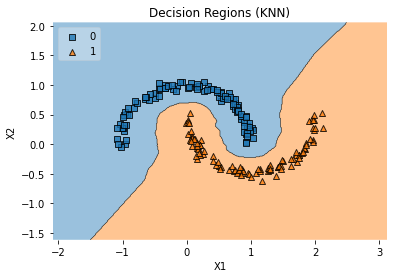

Evaluating model from NB ...
Accuracy (NB): 0.89


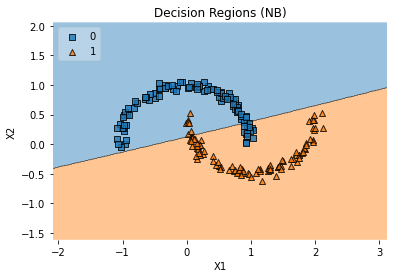

Evaluating model from RL ...
Accuracy (RL): 0.89


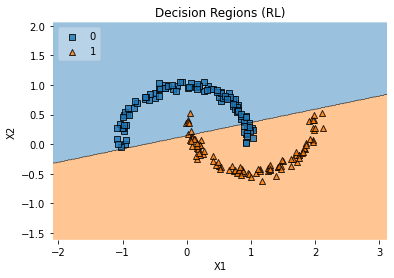

In [32]:
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Evaluating model from {name} ...")
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy ({name}): {round(acc, 2)}")
    
    plot_decision_regions(X_test, y_test, clf=model, legend=2)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Decision Regions (%s)' % name)
    plt.show()